In [1]:
# Model-Based RL - Using a model-based random shooting algorithm to solve HalfCheetah

# Code was used from: https://github.com/ZhengXinyue/Model-Predictive-Control/blob/master/Learning_MPC/Learning_MPC_Pendulum.py
# Got some guidance from the HW: http://rail.eecs.berkeley.edu/deeprlcourse/static/homeworks/hw4.pdf 

### SANITY TEST ##############################################################

# ENVIRONMENT SUMMARY: -> Reacher-v2
# -> Continuous action space

# Observation -> 11 items
#    cos(theta) (first joint)        
#    cos(theta) (second joint)        
#    sin(theta) (first joint)        
#    sin(theta) (second joint)        
#    qpos (the x coordinate of the target )        
#    qpos (the y coordinate of the target )        
#    qvel (the velocity of the fingertip in the x direction )        
#    qvel (the velocity of the fingertip in the y direction )        
#    the x-axis component of the vector from the target to the fingertip        
#    the y-axis component of the vector from the target to the fingertip        
#    the z-axis component of the vector from the target to the fingertip    

# Action -> 2 items
# range from -1 to 1
# most likely correspond to torque of two joints

# Reward -> 1 item

### MAIN #######################################################################

# ENVIRONMENT SUMMARY: -> Cheetah-v2
# -> Continuous action space

# Observation -> 17 items

# Action -> 6 items

# Reward -> 1 item

#################################################################################

import os
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import pickle
import imageio

# TO DO ##########################################################################

# adjust parameters similar to that of HW
# may need to perform multiple training steps per iteration as in HW task -> very slow


# NOTES ##########################################################################

# the principle is that: more rollouts and longer horizon will make better performance.


##################################################################################

# Neural Network Design
def OurModel(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input    
    
    X = Dense(500, activation='relu')(X)
    X = Dense(500, activation='relu')(X)
    X = Dense(action_space)(X)
    
    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['accuracy'])

    return model

# Action Agent
class Agent:
    def __init__(self, env_name):
        
        # environmental variables 
        self.env_name = env_name       
        self.env = gym.make(env_name)
        # self.env.seed(0)  
        self.action_size = self.env.action_space.shape[0] 
        self.state_size = self.env.observation_space.shape[0]
        
        # takes action and previous state as input
        self.input_size = self.action_size + self.state_size
        self.output_size = self.state_size
        self.render = False
        
        # global variables
        self.rollout = 100 #500
        self.horizon = 15   
        
        # training
        self.episodes = 200
        self.batch_size = 128
        
        # initialise memory
        self.replay_length = 100_000
        self.memory = deque(maxlen=self.replay_length)
        
        # model
        self.system_model_1 = OurModel(self.input_size, self.output_size)
        
        #analysis
        self.saved_rewards = []
        
    def angle_normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi
    
    # decide action from state
    def act(self, state_in):         
            
        # reset the state and trajectory
        trajectory_value = np.zeros(self.rollout)
        state = np.tile(state_in, (self.rollout, 1))

        for h in range(self.horizon):

            # select a random action
            action = np.array(np.random.uniform(low=-2.0, high=2.0, size=(self.rollout, self.action_size)), dtype=np.float32) 
            
            if h == 0:
                first_action = action  

            # get the combined state
            combined_state = np.concatenate((state, action), axis=1) 

            # predict the next state     
            diff = (self.system_model_1(combined_state).numpy()).reshape(self.rollout, self.output_size)   
            next_state = state + diff
            
            # get the angles
            cos_theta = next_state[:, 0]
            sin_theta = next_state[:, 1]            
            theta = np.arctan2(sin_theta, cos_theta)
            theta_dot = next_state[:, 2]

            costs = self.angle_normalize(theta) ** 2 + .1 * (theta_dot ** 2) + .001 * (action[0] ** 2)
            trajectory_value += -costs
            state = next_state
        
        best_index = np.argmax(trajectory_value)
        best_action = first_action[best_index]
                
        return best_action
    
    # unpack data from memory 
    def unpack(self):
        
        # sample a minibatch        
        minibatch = np.array(random.sample(self.memory, self.batch_size))
            
        # unpack the data
        state = np.vstack(minibatch[:, 0])
        action = np.vstack(minibatch[:, 1])
        reward = np.vstack(minibatch[:, 2])
        next_state = np.vstack(minibatch[:, 3])
        done = np.vstack(minibatch[:, 4])
        
        return state, action, reward, next_state, done
    
    # train the dynamics model
    def train(self):
                                        
        # access data from replay        
        state, action, _, next_state, _ = self.unpack()
        
        # normalise the difference
        diff = next_state - state
        
        # combine action and state 
        combined_state = np.concatenate((state, action), axis=1)  
        
        # Train the Neural Network with batches
        self.system_model_1.fit(combined_state, diff, batch_size=self.batch_size, verbose=0)
    
    # reset the state
    def reset(self):  
        return self.env.reset()        
    
    # load the model weights
    def load(self, name):
        self.systme_model.load_weights(name) 
    
    # save the model weights
    def save(self, name):
        self.system_model_1.save_weights(name + "_1.h5")
    
    # update the state and reward
    def step(self, action):
        next_state, reward, done, info  = self.env.step(action)        
        return next_state, reward, done, info       
    
    # run the agent    
    def run(self):
        
        frames = []          
        for e in range(1, self.episodes + 1):
            
            print('Starting Episode: ', e)
            state = self.reset()
            done = False
            episode_reward = 0
            frame = 0  
        
            while not done:
                
                # break after 200 frames                
                if frame + 1 % 200 == 0:
                    done = True
                
                # render the environment                
                if self.render:
                    self.env.render()                  
                
                # train the model
                self.train()
                
                # act according to the agent
                action = self.act(state) 
                next_state, reward, done, _ = self.step(action)
                
                # update the replay
                self.memory.append((state, action, reward, next_state, done))  
                #if e > 3: frames.append(self.env.render(mode = 'rgb_array'))  
                
                episode_reward += reward
                frame += 1
                state = next_state

                if done: 
                    
                    # if e > 3: imageio.mimsave('./Images/Pendulum.gif', frames, fps=30)                    
                    
                    print('Episode {} Score: {}'.format(e, episode_reward))
                    self.saved_rewards.append(episode_reward)
                    if e % 10 == 0:   
                        
                        # save the replay                          
                        with open("./Replays/replay1.txt", "wb") as file:
                            pickle.dump(self.memory, file)                            
                        
                        # save results
                        with open("./Results/rewards-ep-" + str(e) + ".txt", "wb") as file:
                            pickle.dump(self.saved_rewards, file) 

                        # save model
                        self.save('./Models/MB_Model')                        
                
                
        self.env.close()
        

# load the replay memory
with open("./Replays/replay_100_000_pend.txt", "rb") as file:
    replay_save = pickle.load(file)          

if __name__ == "__main__":
    # env_name = 'Reacher-v2'
    env_name = 'Pendulum-v0'
    agent = Agent(env_name)
    agent.memory = replay_save
    agent.run()

Starting Episode:  1
Episode 1 Score: -617.7499280205546
Starting Episode:  2
Episode 2 Score: -125.53440257524728
Starting Episode:  3
Episode 3 Score: -123.59526620304499
Starting Episode:  4
Episode 4 Score: -124.87106293820317
Starting Episode:  5
Episode 5 Score: -123.29435078021227


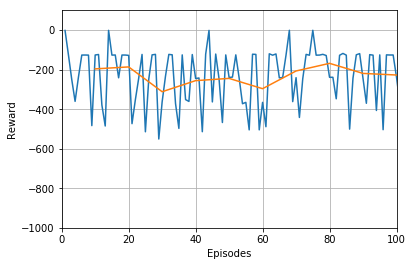

In [4]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt

with open("./Results/rewards-pend-ep-120.txt", "rb") as file:
    a = pickle.load(file)    

mean = []
for i in range(len(a)):
    
    if i % 10 == 0 and i > 0:
        mean.append(np.mean(a[i - 10 : i]))
    
    
x1 = np.array(range(1,12)) * 10
y1 = mean

x2 = np.array(range(1,121)) 
y2 = a

plt.plot(x2,y2)
plt.plot(x1,y1)
plt.xlim(0, 100)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.ylim(-1000, 100)
plt.grid(alpha=1.0)
# plt.savefig('./Images/MD_Pendulum.png')

# plt.show()
        
    